In [3]:
import tensorflow as tf
print(tf.__version__)


2.14.0


In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import uuid
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [10]:
# dataset used for this project
# http://vis-www.cs.umass.edu/lfw/

In [4]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\a5762542-e649-11ee-840d-dad30926883b.jpg'

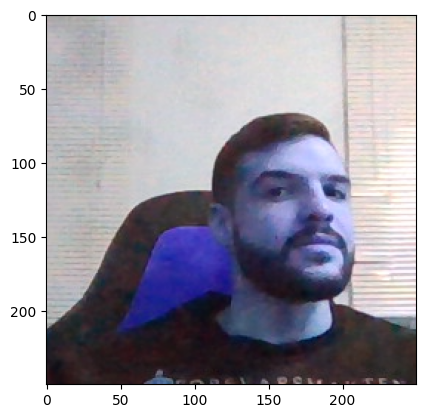

In [26]:
plt.imshow(frame[120:120+250,200:200+250, :])

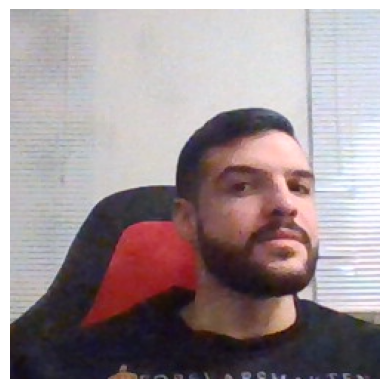

In [25]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
ret, frame = cap.read()

# Make sure the capture was successful
if ret:
    # Define the crop area
    y_start = 120
    x_start = 200
    size = 250
    
    # Check if the frame dimensions are suitable for cropping
    if frame.shape[0] < y_start+size or frame.shape[1] < x_start+size:
        print("The frame is too small to be cropped, try adjusting the crop area.")
    else:
        # Crop the frame
        frame_cropped = frame[y_start:y_start+size, x_start:x_start+size, :]

        # Plot the cropped frame
        plt.imshow(cv2.cvtColor(frame_cropped, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide the axis
        plt.show()
else:
    print("Failed to capture frame")

# Release the webcam
cap.release()
cv2.destroyAllWindows()

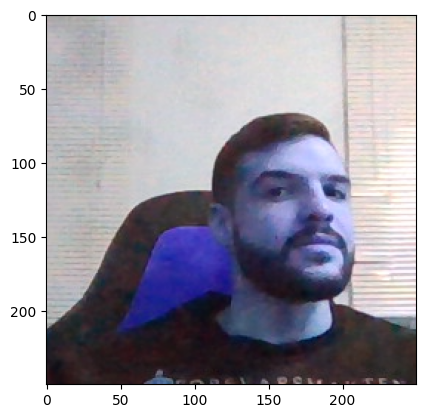

In [27]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [28]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [32]:
# Update the path as per your setup
img_filename = '54e491e7-e64b-11ee-8c9e-dad30926883b.jpg'
img_path = os.path.join(ANC_PATH, img_filename)

# Verify if the file exists before reading
if not os.path.exists(img_path):
    print(f"No file found at {img_path}")
else:
    img = cv2.imread(img_path)

    # Ensure the image was read properly
    if img is None:
        print(f"Failed to read the image from {img_path}")
    else:
        # Convert image to RGB (TensorFlow format) from BGR (OpenCV format)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert to TensorFlow tensor
        img = tf.convert_to_tensor(img, dtype=tf.float32)
        
        # Perform augmentation
        augmented_images = data_aug(img)

        # Write the augmented images to the file system
        for image in augmented_images:
            # Since the images are tensors, convert them to numpy before writing
            cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [33]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [34]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [35]:
dir_test = anchor.as_numpy_iterator()

In [36]:
print(dir_test.next())

b'data\\anchor\\09cbb2db-e64d-11ee-80a7-dad30926883b.jpg'


In [40]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

img = preprocess('data\\anchor\\54e491e7-e64b-11ee-8c9e-dad30926883b.jpg')
img.numpy().max() 

1.0

In [42]:
# (anchor, positive) => 1,1,1,1,1
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# (anchor, negative) => 0,0,0,0,0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)

In [60]:
samples = data.as_numpy_iterator()

example = samples.next()
example

(b'data\\anchor\\11c1eef4-e64b-11ee-a409-dad30926883b.jpg',
 b'data\\positive\\0eda6c7f-e64d-11ee-8f40-dad30926883b.jpg',
 1.0)

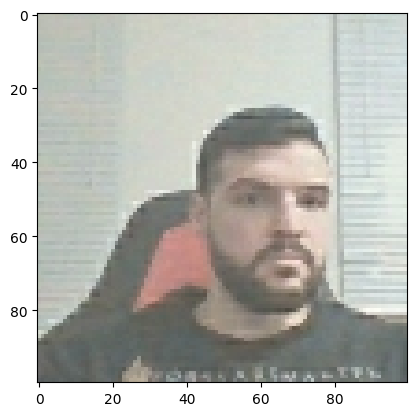

In [48]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*example)
plt.imshow(res[1])

In [50]:
# dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building the Model 

In [62]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall

def make_siamese_model():
    # Define the tensors for the two input images
    input_shape = (100, 100, 3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Define the convolutional neural network
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', 
                     kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-3)))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # Compile the model
    siamese_net.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

    return siamese_net

# Instantiate the model
model = make_siamese_model()


In [63]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 4096)                 2742611   ['input_1[0][0]',             
                                                          2          'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 4096)                 0         ['sequential[0][0]',      

In [65]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()

In [66]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 17, 17, 128)       26

In [67]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
l1 = L1Dist()

In [75]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [77]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [78]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [80]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

In [89]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [91]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [93]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 78s 40s/step
0.7332587 0.25 0.6666667

 Epoch 2/50
2/2 [==============================] - 83s 39s/step
0.6963185 1.0 0.625

 Epoch 3/50
2/2 [==============================] - 84s 40s/step
0.6816993 0.8 0.75

 Epoch 4/50
2/2 [==============================] - 87s 42s/step
0.6929697 0.4 0.85714287

 Epoch 5/50
2/2 [==============================] - 68s 31s/step
0.6206503 0.73333335 1.0

 Epoch 6/50
2/2 [==============================] - 60s 30s/step
0.5913023 0.8235294 1.0

 Epoch 7/50
2/2 [==============================] - 61s 30s/step
0.51175326 0.94736844 1.0

 Epoch 8/50
2/2 [==============================] - 60s 30s/step
0.33563203 0.85714287 1.0

 Epoch 9/50
2/2 [==============================] - 60s 30s/step
0.26618344 1.0 1.0

 Epoch 10/50
2/2 [==============================] -

# 6. Evaluate Model

In [96]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [97]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]

In [98]:
y_true

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [99]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [100]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [101]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 2s 2s/step
1.0 1.0


## Viz Results

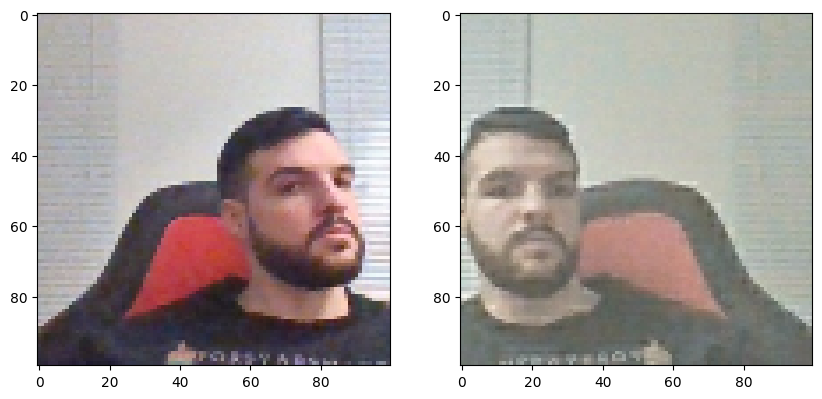

In [102]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Save Model

In [103]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

c:\Users\nkill\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [104]:
L1Dist

__main__.L1Dist

In [105]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [106]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


array([[9.9999934e-01],
       [2.3763134e-06],
       [6.2289041e-07],
       [1.7487150e-04],
       [4.0252853e-06],
       [9.9996960e-01],
       [2.9040290e-05],
       [1.1965254e-06],
       [9.9990755e-01],
       [9.9999696e-01],
       [9.9955171e-01],
       [2.3311930e-05],
       [1.9266168e-05],
       [9.9999630e-01]], dtype=float32)

In [107]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     